# Get Bio-ARGO data
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 21, 2025

>📘 Learning Objectives
>
> 1. Get [Argo data](https://www.aoml.noaa.gov/argo) using the [argopy](https://pypi.org/project/argopy/) Python package
> 2. Learn the basic format of the data grouped into platform and cycles
> 3. Learn how to filter to just surface data
> 4. Learn how to get data in batches

Biogeochemical Argo (“Bio-Argo” or BGC-Argo) floats are autonomous profiling instruments that drift with ocean currents and periodically dive from the surface to depths of 1,000–2,000 meters, collecting a vertical profile of physical and biogeochemical properties. These floats are all over the world's oceans and the data are freely available via the Argo global data assembly centers (GDACs) [Video on the Argo system](https://youtu.be/IixnxfysYAE?si=5xcPe6wa3LoWqUL3).

Each float has a unique PLATFORM_NUMBER, and every time it dives and returns to the surface it produces a new profile, identified by its CYCLE_NUMBER. A single float may produce hundreds of profiles over several years. Bio-Argo floats carry optical, chemical, and physical sensors that measure variables such as chlorophyll-a (CHLA), temperature (TEMP), salinity (PSAL), pressure (PRES, which is used as depth), dissolved oxygen (DOXY), and nitrate (NITRATE). These data are distributed in a consistent, profile-based format: each profile (platform+cycle) contains measurements at multiple depths, along with time, latitude, longitude, and quality-control flags. To use these data for surface-matching with satellite products, we will extract the shallow measurements from each profile (pressure is less than 20dbar or 10dbar). We will use the [argopy](https://pypi.org/project/argopy/) package to download Argo data from the [Coriolis Argo Global Assembly Center](https://coriolis-93c5db.gitlab-pages.ifremer.fr/).

![](Supporting_files/argo_float_cycle.png)

## Workflow

Here is our basic workflow.

1. Use `argopy` to fetch data for Bio-Argo profiles in a given region and time
3. For each profile, save one point, the shallowest reading.
4. Process the globe in monthly chunks to not overload the ERDDAP server and save the monthly shallow points to a parquet file.

See the version 1 notebook for how I save the first files.

In [1]:
!pip install argopy

  Using cached argopy-1.3.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached xarray-2025.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
Using cached argopy-1.3.1-py3-none-any.whl (892 kB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
Using cached xarray-2025.11.0-py3-none-any.whl (1.4 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: xarray━━━━━━━━━━━━━━━━━━ 0/3 [fsspec]
    Found existing installation: xarray 2025.3.1 0/3 [fsspec]
    Uninstalling xarray-2025.3.1:━━━━━━━━━━━ 0/3 [fsspec]
      Successfully uninstalled xarray-2025.3.10m 0/3 [fsspec]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [argopy]2m2/3 [argopy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

## Step 1. Get some data

In this first step we’ll grab some in-situ data from Bio-Argo floats. We use `argopy`’s `ArgoDataFetcher` function to set up a datafetcher object with the information on what dataset (`ds` arg), where (`src` arg) and what parameters. We can access data by a specific buoy (platform), cycle (one descending/ascending cycle of a float), or by region (any data in that region, depth, time). We will use region. Once we set up our datafetcher object, we request the data using a method like `to_xarray()` or `to_dataframe()` to get the data and return in a specific form. We will use `to_xarray()` because the processing by buoy/cycle to get the shallowest points will be easier using xarray.

The code below requests only chlorophyll (CHLA) and pressure (PRES) for March 2024 in our chosen region and returns the result as an xarray Dataset that we can later save as a parquet file.

In [71]:
# get some data
from argopy import DataFetcher as ArgoDataFetcher
# specify the data set and what source
fetcher = ArgoDataFetcher(
    ds="bgc",
    src="erddap",
    params=["CHLA", "PRES"] # both these need to be present
)
# specify that we want to access data in a region; a NW Atlantic box
# lon_min, lon_max, lat_min, lat_max, depth_min, depth_max, time_min, time_max
region = [-70, -40, 20, 60, 0, 1000, "2024-03-01", "2024-04-01"]
fetcher = fetcher.region(region)
fetcher

<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-70.00/-40.00; y=20.00/60.00; z=0.0/1000.0; t=2024-03-01/2024-04-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['CHLA', 'PRES', 'TEMP', 'PSAL']
📕 BGC 'must be measured' parameters: []
🏊 User mode: standard
🟢 Dataset: bgc-s
🌥  Performances: cache=False, parallel=False

In [72]:
# Get the data using the to_xarray() method
ds_na = fetcher.to_xarray()

In [73]:
ds_na

<xarray.Dataset> Size: 1MB
Dimensions:          (N_POINTS: 9267)
Coordinates:
  * N_POINTS         (N_POINTS) int64 74kB 0 1 2 3 4 ... 9263 9264 9265 9266
    LATITUDE         (N_POINTS) float64 74kB 27.53 35.76 23.02 ... 39.93 26.89
    LONGITUDE        (N_POINTS) float64 74kB -50.32 -56.92 ... -68.26 -50.2
    TIME             (N_POINTS) datetime64[ns] 74kB 2024-03-01T05:16:51.00099...
Data variables: (12/21)
    CHLA             (N_POINTS) float32 37kB 0.0036 0.0036 ... 0.005341 0.0
    CHLA_DATA_MODE   (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA_ERROR       (N_POINTS) float32 37kB 0.0072 0.0072 0.02847 ... nan 0.0
    CHLA_QC          (N_POINTS) int64 74kB 1 1 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1
    CYCLE_NUMBER     (N_POINTS) int64 74kB 107 103 78 78 78 ... 21 21 21 21 110
    DIRECTION        (N_POINTS) <U1 37kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...               ...
    PSAL_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 37kB 7.259 7.285 24.82 ... 4.812 7.062
    TEMP_DATA_MODE   (N_POINTS) <U1 37kB 'D' 'D' 'A' 'A' 'A' ... 'R' 'R' 'R' 'D'
    TEMP_ERROR       (N_POINTS) float32 37kB 0.002 0.002 nan ... nan nan 0.002
    TEMP_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 74kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           jovyan
    Fetched_date:         2025/11/22
    Fetched_constraints:  [x=-70.00/-40.00; y=20.00/60.00; z=0.0/1000.0; t=20...
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...
    Processing_history:   [CHLA,PRES,PSAL,TEMP] real-time and adjusted/delaye...

### Plot the data

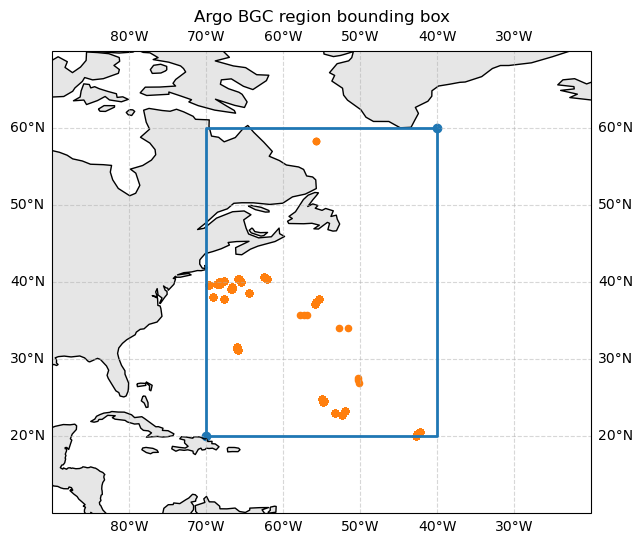

In [6]:
# plot the data; includes all buoys and all depths during each cycle
lon_min, lon_max, lat_min, lat_max = region[:4]
ds = ds_na

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Corners of the box (closed loop)
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Show a bit more context than just the box
ax.set_extent([lon_min - 20, lon_max + 20, lat_min - 10, lat_max + 10], crs=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot the bounding box
ax.plot(lons, lats, transform=proj, linewidth=2)
ax.scatter([lon_min, lon_max], [lat_min, lat_max], transform=proj)

# Add the Argo points from ds
ax.scatter(
    ds["LONGITUDE"].values,
    ds["LATITUDE"].values,
    s=20,
    marker="o",
    transform=proj,
)

ax.set_title("Argo BGC region bounding box")

plt.show()



### Profiles: a descending/ascending cycle

The data for each buoy are organized into cycles which is data collected on one descending/ascending cycle. Depending how the buoy is set up to record data, it might record only on the descending or ascending part of the cycle. The data that the ocean color satellites measure is just the surface. Even if there is high CHLA in deep water, the satellite does not "see" that. Thus we need to filter our cycle data from just the upper layer (< 20 m or so).

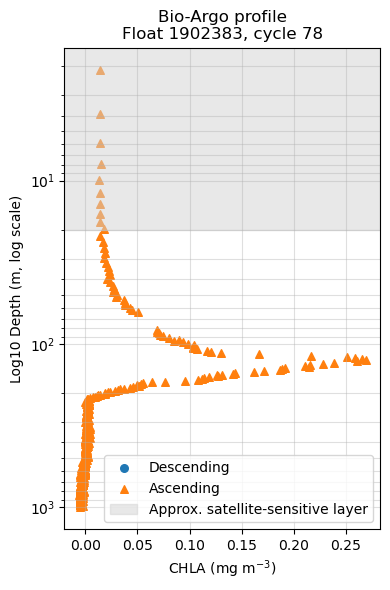

In [37]:
import numpy as np
import matplotlib.pyplot as plt

ds = ds_na  # just to keep the name short

# Unique platform numbers in the dataset
platforms = np.unique(ds["PLATFORM_NUMBER"].values)
plat = int(platforms[0])

# All cycles for that platform
cycles = ds["CYCLE_NUMBER"].where(ds["PLATFORM_NUMBER"] == plat, drop=True)
cycles = np.unique(cycles.values)
cyc = int(cycles[0])

# Select all points belonging to that profile
prof = ds.where(
    (ds["PLATFORM_NUMBER"] == plat) & (ds["CYCLE_NUMBER"] == cyc),
    drop=True
)

chl   = prof["CHLA"]
pres  = prof["PRES"]
direction = prof["DIRECTION"]   # 'A' or 'D'

# Depth in meters ~ pressure in dbar
depth = pres
depth_plot = depth.clip(min=1)  # avoid 0 for log scale

# Masks for ascending/descending
asc_mask = (direction == "A")
des_mask = (direction == "D")

fig, ax = plt.subplots(figsize=(4, 6))

# Plot descending profile
ax.scatter(
    chl.where(des_mask),
    depth_plot.where(des_mask),
    label="Descending",
    s=30,
)

# Plot ascending profile
ax.scatter(
    chl.where(asc_mask),
    depth_plot.where(asc_mask),
    label="Ascending",
    s=30,
    marker="^",
)

# Add a shaded layer representing the satellite-sensitive layer (e.g. 0–20 m)
z_sat = 20  # meters; adjust to taste for your explanation
ax.axhspan(0, z_sat, color="lightgrey", alpha=0.5,
           label="Approx. satellite-sensitive layer")

# Log scale on depth axis, surface at top
ax.set_yscale("log")
ax.invert_yaxis()

ax.set_xlabel("CHLA (mg m$^{-3}$)")
ax.set_ylabel("Log10 Depth (m, log scale)")
ax.set_title(f"Bio-Argo profile\nFloat {plat}, cycle {cyc}")
ax.grid(True, which="both", alpha=0.4)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ds = ds_na  # just to keep the name short

# Unique platform numbers in the dataset
platforms = np.unique(ds["PLATFORM_NUMBER"].values)
plat = int(platforms[0])

# All cycles for that platform
cycles = ds["CYCLE_NUMBER"].where(ds["PLATFORM_NUMBER"] == plat, drop=True)
cycles = np.unique(cycles.values)
cyc = int(cycles[0])

# Select all points belonging to that profile
prof = ds.where(
    (ds["PLATFORM_NUMBER"] == plat) & (ds["CYCLE_NUMBER"] == cyc),
    drop=True
)

time   = prof["TIME"]
pres  = prof["PRES"]

# Depth in meters ~ pressure in dbar
depth = pres
depth_plot = depth.clip(min=1)  # avoid 0 for log scale

fig, ax = plt.subplots(figsize=(4, 6))

# Plot profile
ax.scatter(time, depth_plot, s=30)

# Add a shaded layer representing the satellite-sensitive layer (e.g. 0–20 m)
z_sat = 20  # meters; adjust to taste for your explanation
ax.axhspan(0, z_sat, color="lightgrey", alpha=0.5,
           label="Approx. satellite-sensitive layer")

# Log scale on depth axis, surface at top
ax.set_yscale("log")
ax.invert_yaxis()

ax.set_xlabel("time)")
ax.set_ylabel("Log10 Depth (m, log scale)")
ax.set_title(f"Bio-Argo profile\nFloat {plat}, cycle {cyc}")
ax.grid(True, which="both", alpha=0.4)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Step 2 Filter to only one point (average) from shallow values

We want just a single point, from the < 20m depth, from each of these cycles. We will take the mean of all points in that depth. Our dataframe will have lots of points, but actually very few cycles and fewer cycles that reached the near surface. In this case we had over 9000 points for the whole of March 2024 in the NW Atlantic but only 30 points of near surface CHLA.

In [50]:
# How many row in our dataframe?
df.shape[0]

9267

In [47]:
# Convert to a flat table
df = ds_na.to_dataframe().reset_index()

# Keep only measurements shallower than 20 dbar
df_shallow = df[df["PRES"] < 20]
# Keep only high quality values
df_shallow = df_shallow[df_shallow["CHLA_QC"].isin([1, 2])]

# For each buoy+cycle group, compute surface-layer CHL as the mean CHLA
# and keep some representative metadata (lat/lon/time from the shallow layer)
df_surf = (
    df_shallow
    .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
    .agg(
        CHLA=("CHLA", "mean"),
        CHLA_ERROR=("CHLA_ERROR", "mean"),
        PRES=("PRES", "mean"),
        TEMP=("TEMP", "mean"),
        LATITUDE=("LATITUDE", "first"),
        LONGITUDE=("LONGITUDE", "first"),
        TIME=("TIME", "first"),
        CHLA_count=("CHLA", "count"),  # how many points are averaged
    )
)

print(df_surf.iloc[:5, :])
print("Number of cycles with surface-layer samples:", len(df_surf))

   PLATFORM_NUMBER  CYCLE_NUMBER      CHLA  CHLA_ERROR       PRES       TEMP  \
0          1902383            78  0.017404    0.034807  19.889999  24.718000   
1          1902383            79  0.013333    0.026666  13.980000  25.574713   
2          1902383            80  0.023577    0.047154  15.850000  25.771799   
3          1902384            79  0.027800    0.055601  10.969999  25.717001   
4          1902384            80  0.017258    0.034517  10.051112  26.085335   

   LATITUDE  LONGITUDE                          TIME  CHLA_count  
0   23.0209   -53.2220 2024-03-02 16:13:24.002000128           1  
1   22.7279   -52.3932 2024-03-12 15:19:00.002000128           7  
2   23.2649   -52.0005 2024-03-22 15:28:33.002000128           5  
3   20.0154   -42.7101 2024-03-08 20:58:18.002000128          10  
4   20.3018   -42.5525 2024-03-18 20:31:41.002000128           9  
Number of cycles with surface-layer samples: 25


## Put it together to process the globe

Those are the 2 steps that we will do for each part of the globe and each month since March 2024. We create a function that combines these 2 steps to get one month of data for a region and then we use a for loop to work through the globe. We save the processed monthly data.

### A function to get one month

Get a month for a region. Return a dataframe of the shallow points only. The function allows us to get multiple possible variables like CHLA, DOXY, NITRATE, BBP770, TEMP and PSAL. However if we pass in multiple variables then all must be present, so to maximize the data only pass in one varible at a time unless you need paired measurements.

In [23]:
# get_bgc_surface() function
from pathlib import Path

import numpy as np
import pandas as pd
from argopy import DataFetcher as ArgoDataFetcher


def get_bgc_surface(reg, mon, data_dir="data", vars=None, save=False, pres_max=20):
    """
    Fetch near-surface Bio-Argo data for a region and month and (optionally) save as parquet.

    Parameters
    ----------
    reg : sequence
        [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
        (same as argopy region, but without time bounds).
    mon : str or datetime-like
        Month to fetch, e.g. "2024-03" or "2024-03-01".
    data_dir : str, optional
        Directory where the parquet file will be saved.
    vars : list of str, optional
        Bio-Argo variables to fetch and surface-average (e.g. ["CHLA", "BBP700", "DOXY"]).
        Defaults to ["CHLA"].
    save : bool, optional
        If True, save a parquet file and return (df_surf, path).
        If False, just return (df_surf, None).
    pres_max : float, optional
        Maximum pressure (dbar) for the surface layer (e.g. 20 -> 0–20 dbar).

    Returns
    -------
    df_surf : pandas.DataFrame
        Near-surface samples (one row per profile) with requested variables.
    out_path : str or None
        Path to the saved parquet file, or None if save=False.
    """
    if vars is None:
        vars = ["CHLA"]  # default behaviour

    # Required base columns in the output DataFrame
    base_cols = [
        "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE", "PRES",
    ]

    # De-duplicate and drop any that are base columns (e.g. PRES)
    extra_vars_raw = list(dict.fromkeys(vars))
    extra_vars = [v for v in extra_vars_raw if v not in base_cols]

    # Treat TEMP/PSAL as "extras" too if you want them in the schema
    extras_plus = extra_vars + [v for v in ["TEMP", "PSAL"] if v not in extra_vars]

    # Final schema for the DataFrame: base + extras
    final_cols = base_cols + extras_plus

    lon_min, lon_max, lat_min, lat_max, z_min, z_max = reg

    # Compute start/end of the month
    mon_start = pd.to_datetime(mon).to_period("M").start_time
    mon_end = (mon_start + pd.offsets.MonthBegin(1))

    region = [
        lon_min, lon_max,
        lat_min, lat_max,
        z_min, z_max,
        mon_start.strftime("%Y-%m-%d"),
        mon_end.strftime("%Y-%m-%d"),
    ]

    # STEP 1: Get data for region + month
    # We always request PRES, plus user extras (not TEMP/PSAL unless user asked)
    param_vars = list(dict.fromkeys(extra_vars + ["PRES"]))

    fetcher = ArgoDataFetcher(
        ds="bgc",
        src="erddap",
        params=param_vars,
    )

    try:
        ds = fetcher.region(region).to_xarray()
    except Exception as exc:
        print(f"No data for region={reg}, month={mon}: {exc}")
        # Return empty frame with full schema
        return pd.DataFrame(columns=final_cols), None

    # STEP 2: Filter to approximate surface data
    ds_vars = set(ds.data_vars) | set(ds.coords)

    # We only select columns that exist, but we *remember* full schema in final_cols
    available_cols = [c for c in final_cols if c in ds_vars or c in base_cols]
    # base_cols should all exist in ds/coords
    missing_base_in_ds = [c for c in base_cols if c not in ds_vars]
    if missing_base_in_ds:
        raise ValueError(
            f"Missing required base columns {missing_base_in_ds} in dataset "
            f"for region={reg}, month={mon}"
        )

    df_all = ds[available_cols].to_dataframe().reset_index(drop=True)

    if df_all.empty:
        print(f"No data rows for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None

    # Drop rows with missing PRES
    if "PRES" not in df_all.columns:
        raise ValueError(
            f"'PRES' missing from data for region={reg}, month={mon} "
            "after to_dataframe."
        )

    df_all = df_all.dropna(subset=["PRES"])
    if df_all.empty:
        print(f"No rows with valid PRES for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None

    # Restrict to surface layer
    df_shallow = df_all[df_all["PRES"] < pres_max].copy()
    if df_shallow.empty:
        print(f"No near-surface rows (PRES < {pres_max}) for region={reg}, month={mon}")
        return pd.DataFrame(columns=final_cols), None

    # Ensure all base columns are present before aggregating
    missing_base_shallow = [c for c in base_cols if c not in df_shallow.columns]
    if missing_base_shallow:
        raise ValueError(
            f"Missing required base columns {missing_base_shallow} in shallow data "
            f"for region={reg}, month={mon}"
        )

    # STEP 2a: Base per-profile aggregation
    agg_dict = {
        "PRES": ("PRES", "mean"),
        "LATITUDE": ("LATITUDE", "first"),
        "LONGITUDE": ("LONGITUDE", "first"),
        "TIME": ("TIME", "first"),
    }

    df_surf = (
        df_shallow
        .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
        .agg(**agg_dict)
    )

    # STEP 2b: per-variable surface means (using QC if available)
    for v in extras_plus:
        if v not in df_shallow.columns:
            # We will add it later as NaN for schema consistency
            continue

        df_var = df_shallow.copy()
        qc_col = f"{v}_QC"

        # If a QC column exists, filter by good values
        if qc_col in df_var.columns:
            df_var = df_var[df_var[qc_col].isin([1, 2])]

        if df_var.empty:
            # no good data for this variable; we'll add NaNs later
            continue

        df_surf_var = (
            df_var
            .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
            .agg(**{v: (v, "mean")})
        )

        df_surf = df_surf.merge(
            df_surf_var,
            on=["PLATFORM_NUMBER", "CYCLE_NUMBER"],
            how="left",
        )

    # STEP 2c: ensure all extras exist as columns (NaN if no data)
    for v in extras_plus:
        if v not in df_surf.columns:
            df_surf[v] = np.nan

    # Sanity check: all base_cols must exist now
    missing_base_final = [c for c in base_cols if c not in df_surf.columns]
    if missing_base_final:
        raise ValueError(
            f"After aggregation, missing base columns {missing_base_final} in df_surf "
            f"for region={reg}, month={mon}"
        )

    # Reorder columns to match target schema exactly
    df_surf = df_surf.reindex(columns=final_cols)

    # STEP 3: Save to parquet in data/ dir (optional)
    data_path = Path(data_dir)
    data_path.mkdir(parents=True, exist_ok=True)

    out_fname = (
        f"argo_bgc_{lat_min}_{lat_max}_{lon_min}_{lon_max}_"
        f"{mon_start.strftime('%Y%m')}.parquet"
    )
    out_path = data_path / out_fname

    if save:
        df_surf.to_parquet(out_path, index=False)
        return df_surf, str(out_path)

    return df_surf, None



In [2]:
%%time
# Example
params = ["CHLA", "BBP700", "DOXY"]
# [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
region = [-70, -10, 0, 60, 0, 100]
month = "2024-03"
df_surf, _ = get_bgc_surface(region, month, vars=params)
df_surf.head()

,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,PRES,CHLA,BBP700,DOXY,TEMP,PSAL
0,1902304,155,2024-03-01 21:23:16.002000128,54.6582,-19.2434,10.380000,0.154640,0.000414,258.693817,10.524889,35.415699
1,1902304,156,2024-03-11 20:45:53.002000128,54.9187,-18.9609,10.461111,0.156332,0.000427,259.256744,10.519778,35.414875
2,1902304,157,2024-03-21 21:21:39.002000128,55.2967,-18.8331,10.148889,0.199478,0.000464,261.829529,10.450444,35.413017
3,1902304,158,2024-03-31 21:31:53.002000128,55.7268,-18.8653,10.332222,0.192334,0.000493,261.111633,10.431667,35.407547
4,1902380,79,2024-03-07 18:01:17.002000128,17.6665,-46.0155,10.903333,0.009105,0.000473,206.667984,26.683889,36.246162


### A for loop to work through the whole globe

Loop through the globe and save monthly files. We will do this for all months when there is PACE data. This will take about four hours but we only have to do it once. The `%%script` false is added to prevent accidentally run the cell.

In [24]:
#%%script false --no-raise-error
# comment out the above to run; this just prevents inadvertant running
# since this loops through the whole globe
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Variables to get if avail. NaN if missing
BGC_VARS = ["CHLA"]
out_dir = Path("data/chla_7")
pres_max = 7
# BGC_VARS = ["BBP700"]
# out_dir = Path("data/bbp700")
out_dir.mkdir(parents=True, exist_ok=True)

# Months from 2024-03 up to the current month
start_month = "2024-03"
end_month = pd.Timestamp.today().to_period("M")
months = pd.period_range(start_month, end_month, freq="M")

for mon in months:
    month_str = mon.strftime("%Y-%m")
    out_path = out_dir / f"argo_bgc_global_{month_str}.parquet"

    # Skip if we already have this month (so reruns don't redo everything)
    if out_path.exists():
        print(f"Skipping {month_str}, already have {out_path}")
        continue

    print(f"\n=== Processing month {month_str} ===")

    dfs = []  # collect all boxes for this month

    # Latitude: 45° bands from -90 to 90 -> 4 bands
    for lat_min in range(-90, 90, 45):
        lat_max = lat_min + 45

        # Longitude: 60° bands from -180 to 180 -> 6 bands
        for lon_min in range(-180, 180, 60):
            lon_max = lon_min + 60
            region = [lon_min, lon_max, lat_min, lat_max, 0, 100]
            df_box, _ = get_bgc_surface(region, month_str, vars=BGC_VARS, save=False, pres_max=pres_max)
            if df_box is None or df_box.empty: continue
            dfs.append(df_box)

    # Desired column order (core metadata + all BGC vars)
    base_cols = [
        "TIME", "LATITUDE", "LONGITUDE",
        "PLATFORM_NUMBER", "CYCLE_NUMBER", "PRES", 
    ]
    cols = base_cols + BGC_VARS + ["TEMP", "PSAL"]

    if not dfs:
        print(f"No data at all for month {month_str}, writing empty file")
        df_month = pd.DataFrame(columns=cols)
    else:
        df_month = pd.concat(dfs, ignore_index=True)

        # Make sure all expected columns exist; if missing, add as NaN
        for c in cols:
            if c not in df_month.columns:
                df_month[c] = np.nan

        # Now safely reorder columns
        df_month = df_month[cols]

    # Save one file per month
    df_month.to_parquet(out_path, index=False)
    print(f"Saved {len(df_month)} rows for {month_str} to {out_path}")

Skipping 2024-03, already have data/chla_7/argo_bgc_global_2024-03.parquet
Skipping 2024-04, already have data/chla_7/argo_bgc_global_2024-04.parquet
Skipping 2024-05, already have data/chla_7/argo_bgc_global_2024-05.parquet
Skipping 2024-06, already have data/chla_7/argo_bgc_global_2024-06.parquet
Skipping 2024-07, already have data/chla_7/argo_bgc_global_2024-07.parquet
Skipping 2024-08, already have data/chla_7/argo_bgc_global_2024-08.parquet
Skipping 2024-09, already have data/chla_7/argo_bgc_global_2024-09.parquet
Skipping 2024-10, already have data/chla_7/argo_bgc_global_2024-10.parquet

=== Processing month 2024-11 ===


No data rows for region=[-120, -60, -90, -45, 0, 100], month=2024-11
No near-surface rows (PRES < 7) for region=[-120, -60, 45, 90, 0, 100], month=2024-11
No data for region=[60, 120, 45, 90, 0, 100], month=2024-11: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2024-11
Saved 513 rows for 2024-11 to data/chla_7/argo_bgc_global_2024-11.parquet
Skipping 2024-12, already have data/chla_7/argo_bgc_global_2024-12.parquet
Skipping 2025-01, already have data/chla_7/argo_bgc_global_2025-01.parquet
Skipping 2025-02, already have data/chla_7/argo_bgc_global_2025-02.parquet
Skipping 2025-03, already have data/chla_7/argo_bgc_global_2025-03.parquet
Skipping 2025-04, already have data/chla_7/argo_bgc_global_2025-04.parquet

=== Processing month 2025-05 ===


No data rows for region=[-120, -60, 45, 90, 0, 100], month=2025-05
No data for region=[60, 120, 45, 90, 0, 100], month=2025-05: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-05
Saved 740 rows for 2025-05 to data/chla_7/argo_bgc_global_2025-05.parquet

=== Processing month 2025-06 ===


No data rows for region=[-120, -60, 45, 90, 0, 100], month=2025-06
No data for region=[60, 120, 45, 90, 0, 100], month=2025-06: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-06
Saved 674 rows for 2025-06 to data/chla_7/argo_bgc_global_2025-06.parquet

=== Processing month 2025-07 ===
No data for region=[60, 120, 45, 90, 0, 100], month=2025-07: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-07
Saved 645 rows for 2025-07 to data/chla_7/argo_bgc_global_2025-07.parquet

=== Processing month 2025-08 ===
No data for region=[60, 120, 45, 90, 0, 100], month=2025-08: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-08
Saved 688 rows for 2025-08 to data/chla_7/argo_bgc_global_2025-08.parquet

=== Processing month 2025-09 ===
No data for region=[60, 120, 45, 90, 0, 100], month=2025-09: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-09
Saved 689 rows for 2025-09 to data/chla_7/argo_bgc_global_2025-09.parquet

=== Processing month 2025-10 ===
No data for region=[60, 120, 45, 90, 0, 100], month=2025-10: 'CHLA' not available for this access point. The 'params' argument must have values in [DOXY,PRES,PSAL,TEMP]


No data rows for region=[120, 180, 45, 90, 0, 100], month=2025-10
Saved 721 rows for 2025-10 to data/chla_7/argo_bgc_global_2025-10.parquet

=== Processing month 2025-11 ===
No data for region=[60, 120, 45, 90, 0, 100], month=2025-11: 'No data found in the index corresponding to your search criteria. Search definition: x=60.00/120.00;y=45.00/90.00;t=2025-11-01/2025-12-01'
No near-surface rows (PRES < 7) for region=[120, 180, 45, 90, 0, 100], month=2025-11
Saved 562 rows for 2025-11 to data/chla_7/argo_bgc_global_2025-11.parquet


## Merge all together into one parquet

In [3]:
# example of one file
from pathlib import Path
import numpy as np
import pandas as pd

var_dir = Path("data/chla")
files = sorted(var_dir.glob("argo_bgc_global_*.parquet"))
df = pd.read_parquet(files[0])
df

,TIME,LATITUDE,LONGITUDE,PLATFORM_NUMBER,CYCLE_NUMBER,PRES,CHLA,TEMP,PSAL
0,2024-03-01 15:11:04.002000128,-49.643800,-154.520400,5906311,115,11.020000,1.185197,13.093500,34.594406
1,2024-03-11 15:26:06.002000128,-49.911800,-153.935800,5906311,116,10.221111,1.443537,13.574444,34.602802
2,2024-03-21 14:29:38.002000128,-49.907700,-152.864700,5906311,117,10.880000,1.363146,13.706301,34.503258
3,2024-03-31 14:47:29.002000128,-49.520700,-151.631500,5906311,118,10.960001,1.156802,13.522700,34.376629
4,2024-03-02 07:20:27.000999936,-50.550600,-126.866200,5906444,47,10.572223,0.478140,10.031666,34.216404
...,...,...,...,...,...,...,...,...,...
488,2024-03-05 11:32:39.019000064,69.673916,4.204859,7901028,55,1.020000,0.021900,5.909500,35.102501
489,2024-03-11 05:30:41.015000064,69.274508,2.537495,7901028,56,1.256754,0.135456,6.698943,35.136322
490,2024-03-16 11:32:39.024000000,68.702584,3.804852,7901028,57,1.214967,0.153300,5.696755,35.107090
491,2024-03-21 17:40:41.012999936,68.602906,6.045098,7901028,58,1.500066,0.222650,5.852717,35.102001


In [2]:
# function to process the monthly files
from pathlib import Path
import numpy as np
import pandas as pd

def merge_bgc_monthlies(var_dir, out_path, var_name):
    """
    Merge monthly Bio-Argo parquet files for a single variable (e.g., CHLA or BBP700).

    Parameters
    ----------
    var_dir : str or Path
        Directory containing monthly parquet files like 'argo_bgc_global_YYYY-MM.parquet'.
    out_path : str or Path
        Output parquet path for the merged dataset.
    var_name : str
        Name of the BGC variable column in the files (e.g., 'CHLA', 'BBP700').
    """
    var_dir = Path(var_dir)
    files = sorted(var_dir.glob("argo_bgc_global_*.parquet"))

    if not files:
        raise FileNotFoundError(f"No parquet files found in {var_dir}")

    dfs = []
    for f in files:
        print(f"Reading {f}")
        df = pd.read_parquet(f)
        dfs.append(df)

    # Concatenate all months
    df_all = pd.concat(dfs, ignore_index=True)

    # Core columns you want
    base_cols = [
        "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE", "PRES",
    ]

    # TEMP and PSAL if present, otherwise we’ll add as NaN
    extra_cols = ["TEMP", "PSAL", var_name]

    # Ensure all expected columns exist; They should be there, but just in case
    for c in base_cols + extra_cols:
        if c not in df_all.columns:
            df_all[c] = np.nan

    # Final column order
    cols = base_cols + extra_cols
    df_all = df_all[cols]

    # Save merged parquet
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_parquet(out_path, index=False)
    print(f"Saved merged dataset with {len(df_all)} rows to {out_path}")


In [6]:
%%script false --no-raise-error
# %%script to prevent accidentally rerunning this code
outfile = "tutorial_data/argo_bgc_global_surface_BBP700.parquet"
merge_bgc_monthlies("data/bbp700", outfile, "BBP700")
outfile = "tutorial_data/argo_bgc_global_surface_CHLA.parquet"
merge_bgc_monthlies("data/chla", outfile, "CHLA")

Reading data/bbp700/argo_bgc_global_2024-03.parquet
Reading data/bbp700/argo_bgc_global_2024-04.parquet
Reading data/bbp700/argo_bgc_global_2024-05.parquet
Reading data/bbp700/argo_bgc_global_2024-06.parquet
Reading data/bbp700/argo_bgc_global_2024-07.parquet
Reading data/bbp700/argo_bgc_global_2024-08.parquet
Reading data/bbp700/argo_bgc_global_2024-09.parquet
Reading data/bbp700/argo_bgc_global_2024-10.parquet
Reading data/bbp700/argo_bgc_global_2024-11.parquet
Reading data/bbp700/argo_bgc_global_2024-12.parquet
Reading data/bbp700/argo_bgc_global_2025-01.parquet
Reading data/bbp700/argo_bgc_global_2025-02.parquet
Reading data/bbp700/argo_bgc_global_2025-03.parquet
Reading data/bbp700/argo_bgc_global_2025-04.parquet
Reading data/bbp700/argo_bgc_global_2025-05.parquet
Reading data/bbp700/argo_bgc_global_2025-06.parquet
Reading data/bbp700/argo_bgc_global_2025-07.parquet
Reading data/bbp700/argo_bgc_global_2025-08.parquet
Reading data/bbp700/argo_bgc_global_2025-09.parquet
Reading data

## Load data

If you have the data file on your computer, you load as below. However the parquet files are in the tutorials data directory in our GitHub repository and you can load from that.

In [17]:
%%script false --no-raise-error
# Load from local file
from pathlib import Path
import numpy as np
import pandas as pd

file = "tutorial_data/argo_bgc_global_surface_CHLA.parquet"
df = pd.read_parquet(file)
df.shape

In [18]:
# Load data from GitHub
import pandas as pd
url = "https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/tutorial_data/argo_bgc_global_surface_CHLA.parquet"
df = pd.read_parquet(url)
df.head()

,PLATFORM_NUMBER,CYCLE_NUMBER,TIME,LATITUDE,LONGITUDE,PRES,TEMP,PSAL,CHLA
0,5906311,115,2024-03-01 15:11:04.002000128,-49.6438,-154.5204,11.020000,13.093500,34.594406,1.185197
1,5906311,116,2024-03-11 15:26:06.002000128,-49.9118,-153.9358,10.221111,13.574444,34.602802,1.443537
2,5906311,117,2024-03-21 14:29:38.002000128,-49.9077,-152.8647,10.880000,13.706301,34.503258,1.363146
3,5906311,118,2024-03-31 14:47:29.002000128,-49.5207,-151.6315,10.960001,13.522700,34.376629,1.156802
4,5906444,47,2024-03-02 07:20:27.000999936,-50.5506,-126.8662,10.572223,10.031666,34.216404,0.478140


### Plot the data

Some regions are better represented that others.

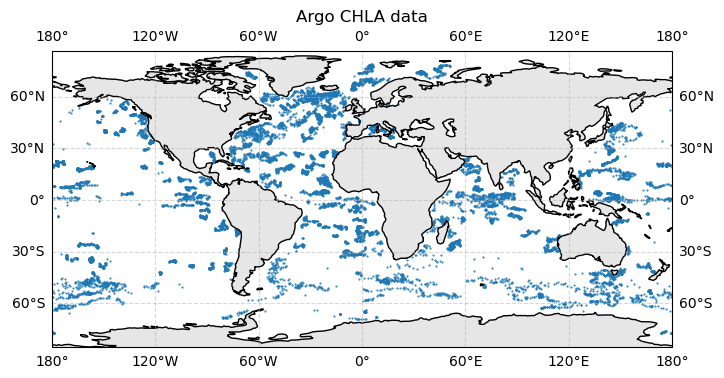

In [16]:
# plot the data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Add the Argo points from df
ax.scatter(
    df["LONGITUDE"].values,
    df["LATITUDE"].values,
    s=1,
    marker=".",
    transform=proj,
)

ax.set_title("Argo CHLA data")

plt.show()


## Summary

Now we have in-situ CHLA and BBP700 data. For our machine-learning, we need to match these points to PACE data and extract the PACE variables for each lat/lon/time point.